### EXP: Full launch QC rating 

- **Aim:** First full launch of quality control (QC) of brain registration on the Zooniverse platform. Raters are some of zooniverse users ( ref: https://www.zooniverse.org/projects/simexp/brain-match ).

- **Exp:** 
    - We choose 100 anatomical brain images (?? OK, ?? Maybe and ?? Fail)   preprocced with NIAK pipelines from ADHD200 and COBRE datsets.
    - We asked raters on the Zooniverse platform to QC images based on the tutorial and the rated sample images.

In [1]:
import os
import pandas as pd
import numpy as np
import json
import itertools
import seaborn as sns
from sklearn import metrics
from matplotlib import gridspec as gs
import matplotlib.pyplot as plt
from functools import reduce

In [2]:
%matplotlib inline
%load_ext rpy2.ipython
sns.set(style="white")

In [3]:
def CustomParser(data):
    j1 = json.loads(data)
    return j1

In [4]:
# Read raw table
classifications = pd.read_csv('../data/rating/brain-match-classifications-12-10-2018.csv', 
                              converters={'metadata':CustomParser,
                                          'annotations':CustomParser,
                                          'subject_data':CustomParser},
                              header=0)

In [5]:
# List all workflows 
classifications.workflow_name.unique()

array(['Spot anatomical differences', 'Spot functional differences',
       'anat_internal_rating_pierre', 'anat_internal_rating_yassine',
       'Training Session', 'Basile', 'Benjamin', 'Maxime', 'Angela',
       'Sara', 'Pierre_func_rate_1', 'Pierre_anat_rate1',
       'Yassine_func_rate_1', 'Pierre_func_rate_2', 'Start Project',
       'Start Project 1', 'Expert Project 1', 'Expert Project 2',
       'Start Project 2'], dtype=object)

In [6]:
# Filter out only specific workflow
ratings = classifications.loc[classifications['workflow_name'].isin(['Start Project 1'])]
ratings.count()

classification_id    4351
user_name            4351
user_id              3718
user_ip              4351
workflow_id          4351
workflow_name        4351
workflow_version     4351
created_at           4351
gold_standard           0
expert                  0
metadata             4351
annotations          4351
subject_data         4351
subject_ids          4351
dtype: int64

In [20]:
# extract tagging count
ratings.loc[:,"n_tagging"] = [ len(q[0]['value']) for q in ratings.annotations]

# extract rating count
ratings.loc[:,"rating"] = [ q[1]['value'] for q in ratings.annotations]

# extract subjects id
ratings.loc[:,"ID"] = [ row.subject_data[str(ratings.subject_ids.loc[ind])]['subject_ID'] for ind,row in ratings.iterrows()]

# extract files name
ratings.loc[:,"imgnm"] = [ row.subject_data[str(ratings.subject_ids.loc[ind])]['image1'] for ind,row in ratings.iterrows()]


In [21]:
# Extract two expert raters ('colezweber','ppf') and save them for after  
expert_ = ratings[ratings.user_name.isin([ 'colezweber','ppf','jenichen'])]
# Save to csv
expert_.to_csv('../data/rating/Full_launch1_ppf-colezweber.csv',index=False)

In [22]:
# Remove experts and one outlier
ratings = ratings[~ratings.user_name.isin(['jenichen','colezweber','ppf','willy71'])]

In [23]:
# How many rating per user
user_count_raw = ratings.user_name.value_counts()
list_user_raw = user_count_raw.index
user_count_raw.head()

MsImmortal         126
lobusparietalis    105
1010101            103
alinanaseer        103
sueburr            102
Name: user_name, dtype: int64

In [36]:
# drop duplicated rating
inc = 0
sum_dup = 0
for ind,user in enumerate(ratings.user_name.unique()):
    user_select_df = ratings[ratings.user_name.isin([user])]
    mask=~user_select_df.ID.duplicated()
    dup = len([m for m in mask if m == False])
    sum_dup = sum_dup+ dup
    if dup > 0 :
        print('{} have {} duplicated ratings'.format(user,dup))
    if ind == 0 and inc == 0:
        classi_unique= user_select_df[mask]
        inc+=1
    else:
        classi_unique = classi_unique.append(user_select_df[~user_select_df.ID.duplicated()])
        inc+=1
print('Total number of duplicated ratings  = {}'.format(sum_dup))

not-logged-in-c837bd9b6e0e19ead70a have 1 duplicated ratings
hallkr have 1 duplicated ratings
not-logged-in-24351783cda51e314716 have 1 duplicated ratings
1a2r3u4n have 2 duplicated ratings
MsImmortal have 26 duplicated ratings
not-logged-in-bd56c1b642fe9a396968 have 3 duplicated ratings
lobusparietalis have 5 duplicated ratings
Dillen have 1 duplicated ratings
not-logged-in-f65397cff142bf3ca722 have 2 duplicated ratings
not-logged-in-e6cdaaf2c1ee477aaecb have 1 duplicated ratings
not-logged-in-7715f3dcb14df1943100 have 8 duplicated ratings
ritu99 have 1 duplicated ratings
1010101 have 3 duplicated ratings
not-logged-in-1482d11fba86b2ce0126 have 1 duplicated ratings
kitchenmi have 1 duplicated ratings
sueburr have 2 duplicated ratings
not-logged-in-b7ef785608cf8dff0161 have 5 duplicated ratings
not-logged-in-4d11726c1f714afe8e57 have 12 duplicated ratings
not-logged-in-b1501dc76ba056d8bab2 have 1 duplicated ratings
ashherr17 have 16 duplicated ratings
alinanaseer have 39 duplicated rat

In [37]:
# Get raters list that ratded more than 20 images 
list_user = classi_unique.user_name.value_counts().index
list_user = list_user[user_count.values>=20]

In [38]:
# remove users with less rating then the selected threshold
classi_unique = classi_unique[classi_unique.user_name.isin(list_user)]
classi_unique.count()

classification_id    2157
user_name            2157
user_id              2031
user_ip              2157
workflow_id          2157
workflow_name        2157
workflow_version     2157
created_at           2157
gold_standard           0
expert                  0
metadata             2157
annotations          2157
subject_data         2157
subject_ids          2157
n_tagging            2157
rating               2157
ID                   2157
imgnm                2157
dtype: int64

In [43]:
image_count

HC0040055    27
X1743472     26
X0010031     26
HC0040051    26
X2297413     26
X0021046     26
HC0040048    25
X6568351     25
X0010061     25
X3051944     25
X3684229     25
X4362730     25
HC0040054    25
X2081148     25
X2288903     25
X3912996     25
X3662296     25
X0010007     25
X2054998     25
X0023019     24
X0023027     24
HC0040052    24
HC0040038    24
X3560456     24
HC0040043    24
X3433846     23
X0021015     23
X0010067     23
HC0040056    23
HC0040061    23
             ..
X2740232     20
X1647968     20
X0010032     20
X1038415     20
X3848511     20
X2996531     19
X0021020     19
X0010049     19
X0026024     19
X4104523     19
X0026022     19
X0010029     19
X3902469     19
X0026016     19
X2030383     19
X0026039     19
X0010013     19
X8628223     18
X1962503     18
X1552181     18
HC0040058    18
X2443191     18
X2138826     17
X3011311     17
X0010088     17
X3169448     17
X1481430     16
X0010120     16
X0010033     16
X0010038     15
Name: ID, Length: 100, d

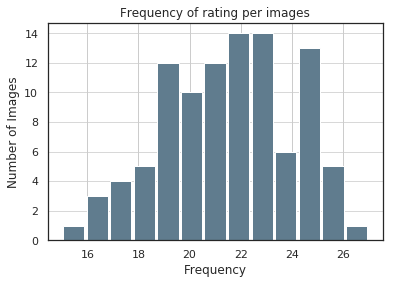

In [55]:
# plot rating per image distribution
image_count = classi_unique.ID.value_counts()
image_count.plot.hist(grid=True,rwidth=0.9, bins=13,color='#607c8e')
plt.title('Frequency of rating per images')
plt.xlabel('Frequency')
plt.ylabel('Number of Images')
plt.grid(axis='y', alpha=0.75)

In [56]:
#Create Users rating dataframe
concat_rating = [classi_unique[classi_unique.user_name == user][['ID','rating']].rename(columns={'rating': user})
                  for user in list_user]

df_ratings = reduce(lambda left,right: pd.merge(left,right,how='outer',on='ID'), concat_rating)
# remove duplicates
df_ratings = df_ratings[~df_ratings.ID.duplicated()]
# anonymise user names
user_ =['ID'] + ['S' + str(ii) for ii in range(len(df_ratings.columns)-1)]
df_ratings.columns = user_
df_ratings.head()

,ID,S0,S1,S2,S3,S4,S5,S6,S7,S8,...,S31,S32,S33,S34,S35,S36,S37,S38,S39,S40
0,X0010061,OK,Maybe,Maybe,Fail,Maybe,Maybe,Fail,Maybe,Maybe,...,NaN,Fail,NaN,NaN,NaN,NaN,NaN,NaN,OK,NaN
1,HC0040048,OK,OK,OK,Maybe,Maybe,OK,Maybe,Maybe,OK,...,NaN,Maybe,Fail,NaN,NaN,NaN,NaN,NaN,NaN,OK
2,X2854839,Maybe,Maybe,Maybe,Maybe,Maybe,OK,Maybe,Maybe,Maybe,...,NaN,Maybe,NaN,NaN,NaN,NaN,Fail,NaN,Maybe,NaN
3,X2081148,Maybe,Maybe,OK,Fail,OK,OK,OK,OK,OK,...,NaN,NaN,NaN,NaN,OK,NaN,OK,NaN,NaN,OK
4,X3902469,Maybe,Maybe,Maybe,Maybe,Fail,OK,OK,OK,Maybe,...,NaN,NaN,NaN,OK,NaN,NaN,NaN,NaN,NaN,Maybe


In [87]:
# add ratinng coount per image
distrib = [row[1:].count() for ind,row in df_ratings.iterrows()]
df_ratings.loc[:,'num_rat'] = distrib
df_ratings.to_csv('../data/rating/full_launch_zooniverse_raters_included.csv',index=False)
df_ratings.head()

,ID,S0,S1,S2,S3,S4,S5,S6,S7,S8,...,S32,S33,S34,S35,S36,S37,S38,S39,S40,num_rat
0,X0010061,OK,Maybe,Maybe,Fail,Maybe,Maybe,Fail,Maybe,Maybe,...,Fail,NaN,NaN,NaN,NaN,NaN,NaN,OK,NaN,26
1,HC0040048,OK,OK,OK,Maybe,Maybe,OK,Maybe,Maybe,OK,...,Maybe,Fail,NaN,NaN,NaN,NaN,NaN,NaN,OK,26
2,X2854839,Maybe,Maybe,Maybe,Maybe,Maybe,OK,Maybe,Maybe,Maybe,...,Maybe,NaN,NaN,NaN,NaN,Fail,NaN,Maybe,NaN,23
3,X2081148,Maybe,Maybe,OK,Fail,OK,OK,OK,OK,OK,...,NaN,NaN,NaN,OK,NaN,OK,NaN,NaN,OK,26
4,X3902469,Maybe,Maybe,Maybe,Maybe,Fail,OK,OK,OK,Maybe,...,NaN,NaN,OK,NaN,NaN,NaN,NaN,NaN,Maybe,20


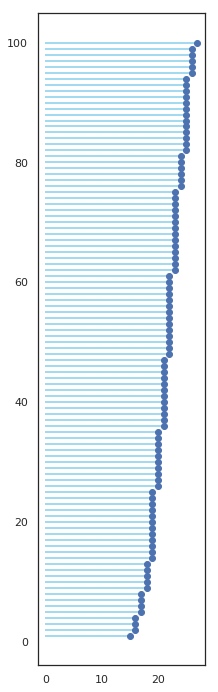

In [58]:
# plot ditribution of ratings per images
plt.figure(figsize=(3,12))
# Reorder it following the values:
ordered_df = df_ratings.sort_values(by='num_rat')
my_range=range(1,len(df_ratings.index)+1)
 
# The vertival plot is made using the hline function
# I load the seaborn library only to benefit the nice looking feature
import seaborn as sns
plt.hlines(y=my_range, xmin=0, xmax=ordered_df['num_rat'], color='skyblue')
plt.plot(ordered_df['num_rat'], my_range, "o")


### Explore the concensus of rating between images

In [59]:
# Get ratings from images rated more tan N different rates 
n = 4 # Minimun number of ratings per image
stuff = np.array([[row.ID,
                   np.sum(row[1:].values=='Fail'),
                   np.sum(row[1:].values=='Maybe'),
                   np.sum(row[1:].values=='OK')]  
                  for ind, row in df_ratings.iterrows() if np.sum([np.sum(row[1:-1].values=='Fail'),
                                                                 np.sum(row[1:-1].values=='Maybe'),
                                                                 np.sum(row[1:-1].values=='OK')]) >= n])
df_score = pd.DataFrame(data=stuff, columns=['ID','Fail', 'Maybe', 'OK'])
df_score.head()

,ID,Fail,Maybe,OK
0,X0010061,9,8,8
1,HC0040048,5,9,11
2,X2854839,4,16,2
3,X2081148,2,6,17
4,X3902469,1,11,7


In [60]:
# Normalise table's row
df_score_tmp = df_score[['Fail','Maybe','OK']].astype('int')
nb_rating = df_score[['Fail','Maybe','OK']].astype('int').sum(axis="columns")
df_norm = pd.DataFrame( index=df_score.index,columns=['ID','Fail', 'Maybe', 'OK'])
for status in ['Fail','Maybe','OK']:
    for image in df_score.index:
        df_norm[status][image] = np.int(df_score[status][image])/nb_rating[image]
        df_norm['ID'][image] = df_score['ID'][image]
# get max value
max_value = [row.iloc[1:].get_values().max() for ind,row in df_norm.iterrows()]
df_norm.loc[:,'max_value_NoExp'] = max_value
# get concensus rating
s = ['Fail', 'Maybe', 'OK']
#max_rate = [row.iloc[1:].idxmax(axis=1) for ind,row in df_norm.iterrows()]
max_rate = [s[row[1:].values.argmax()] for rid, row in df_norm.iterrows()]
df_norm.loc[:,'concensus_NoExp'] = max_rate
df_norm.head()

,ID,Fail,Maybe,OK,max_value_NoExp,concensus_NoExp
0,X0010061,0.36,0.32,0.32,0.360000,Fail
1,HC0040048,0.2,0.36,0.44,0.440000,OK
2,X2854839,0.181818,0.727273,0.0909091,0.727273,Maybe
3,X2081148,0.08,0.24,0.68,0.680000,OK
4,X3902469,0.0526316,0.578947,0.368421,0.578947,Maybe


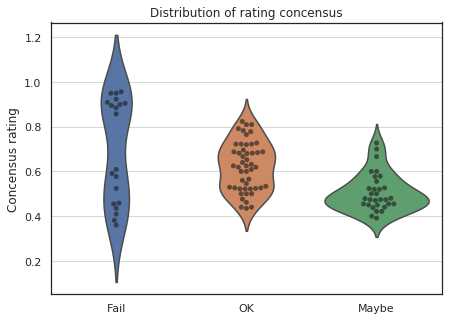

In [61]:
#Setting the figure with matplotlib
plt.figure(figsize=(7,5))
#plt.xticks(rotation=90)
plt.rcParams["axes.labelsize"] = 12
 
#Creating the desired plot
sns.violinplot(x='concensus_NoExp',y='max_value_NoExp',data=df_norm,
              inner=None #removes the inner bars inside the violins 
              )
 
sns.swarmplot(x='concensus_NoExp',y='max_value_NoExp',data=df_norm,
             color='k',#for making the points black
             alpha=0.6) #value of alpha will increase the transparency
 
#Title for the plot
plt.grid(axis='y', alpha=0.75)
plt.title('Distribution of rating concensus')
plt.xlabel('')
plt.ylabel('Concensus rating')
plt.savefig('../reports/figures/concensus_zooniverse.svg')

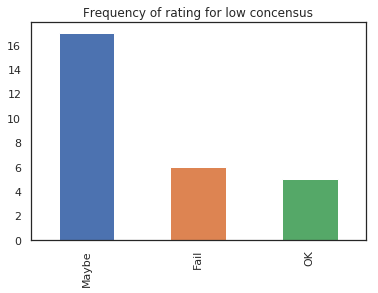

In [62]:
count_ = df_norm.concensus_NoExp[[0 <= row.max_value_NoExp < 0.5   for ind, row in df_norm.iterrows() ]].value_counts()
axes = count_.plot.bar(title = 'Frequency of rating for low concensus')

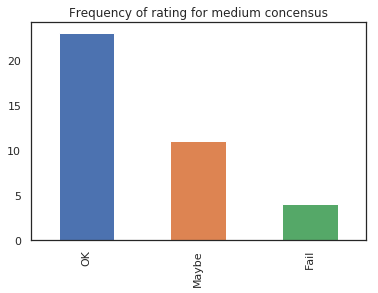

In [63]:
count_ = df_norm.concensus_NoExp[[0.5 <= row.max_value_NoExp < 0.65   for ind, row in df_norm.iterrows() ]].value_counts()
axes = count_.plot.bar(title = 'Frequency of rating for medium concensus')

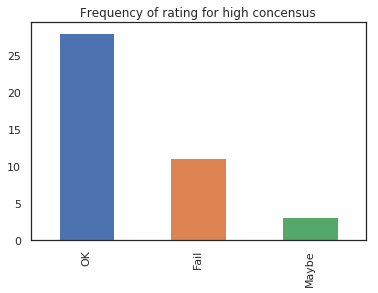

In [64]:
count_ = df_norm.concensus_NoExp[[0.6 < row.max_value_NoExp <= 1   for ind, row in df_norm.iterrows() ]].value_counts()
axes = count_.plot.bar(title = 'Frequency of rating for high concensus')

In [65]:
# Save a copy of concensus
df_norm[['ID','max_value_NoExp','concensus_NoExp']].rename(columns={'concensus_NoExp':'Zcon','max_value_NoExp':'ZconVal'}).to_csv('../data/rating/full_launch_zooniverse_consensus.csv',index=False)

### Merge Pilot3 and Full launch 1 rating and get Kappa score

In [329]:
pilot3 = pd.read_csv('../data/rating/Pilot3_internal_rating.csv')
pilot3.head()

,ID,Yben,Pbel,Bpin,Sdup,Atam,Mpel,Bdel,Cons_P3
0,SZ0040029,OK,Maybe,OK,Maybe,OK,Fail,Maybe,Maybe
1,SZ0040039,OK,OK,Fail,OK,Maybe,OK,OK,OK
2,SZ0040042,OK,OK,Maybe,Maybe,OK,Fail,OK,Maybe
3,SZ0040044,OK,OK,Fail,OK,OK,Maybe,OK,OK
4,SZ0040046,OK,OK,Maybe,Maybe,OK,Maybe,OK,Maybe


In [330]:
# Merge 
merge_ratings = pd.merge(pilot3,df_norm[['ID','concensus_NoExp']],on='ID',how='inner').apply(lambda x: x.str.strip() if x.dtype == "object" else x)
merge_ratings.rename(columns={'concensus_NoExp':'Cons_F1'},inplace=True)
merge_ratings.head()

,ID,Yben,Pbel,Bpin,Sdup,Atam,Mpel,Bdel,Cons_P3,Cons_F1
0,X0026002,Maybe,Maybe,Fail,Fail,Maybe,Maybe,Maybe,Maybe,Maybe
1,X3848511,Maybe,Maybe,Fail,Maybe,Maybe,Maybe,Maybe,Maybe,Maybe
2,X3107623,OK,OK,OK,Maybe,Maybe,Maybe,Fail,Maybe,OK
3,X3433846,Maybe,Maybe,Fail,Fail,Maybe,OK,Fail,Fail,OK
4,X3163200,Maybe,OK,Fail,OK,Maybe,Fail,Maybe,Fail,Maybe


In [331]:
# Replace OK with 1 , Maybe with 2 and Fail with 3
merge_ratings.replace({'OK':1,'Maybe':2, 'Fail':3}, inplace=True)
merge_ratings.rename(columns={'bpinsard':'Bpin',
                              'saradupont':'Sdup',
                              'angelatam':'Atam',
                              'hereinlies':'Mpel',
                              'benjamindeleener':'Bdel'},inplace=True)
merge_ratings = merge_ratings[['ID','Yben','Pbel','Atam','Bdel','Sdup','Mpel','Bpin','Cons_F1']]
merge_ratings.head()

,ID,Yben,Pbel,Atam,Bdel,Sdup,Mpel,Bpin,Cons_F1
0,X0026002,2,2,2,2,3,2,3,2
1,X3848511,2,2,2,2,2,2,3,2
2,X3107623,1,1,2,3,2,2,1,1
3,X3433846,2,2,2,3,3,1,3,1
4,X3163200,2,1,2,2,1,3,3,2


In [332]:
%%R
suppressPackageStartupMessages(library(dplyr))
#install.packages("irr") 
library(irr)

In [333]:
# Percenteage of agrrement between raters with R package IRR
agree_ = merge_ratings.drop(['ID'],axis=1)
%Rpush agree_
agree_n = %R agree(agree_)
print(agree_n)

 Percentage agreement (Tolerance=0)

 Subjects = 29 
   Raters = 8 
  %-agree = 31 



In [334]:
# FDR correction
from statsmodels.sandbox.stats import multicomp as smi

def fdr_transf(mat,log10 = False):
    '''compute fdr of a given matrix'''
    
    row = mat.shape[0]
    col = mat.shape[1]
    flatt = mat.flatten()
    fdr_2d = smi.multipletests(flatt, alpha=0.05, method='fdr_bh')[1]
    if log10 == True:
        fdr_2d = [-np.log10(ii) if ii != 0 else 50 for ii in fdr_2d  ]
    fdr_3d = np.reshape(fdr_2d,(row,col))
    return fdr_3d

In [335]:
# Kappa calculation
def kappa_score(k_df,log10 = False):
    '''compute Kappa between diferent raters organized in dataframe'''
    k_store = np.zeros((len(k_df.columns), len(k_df.columns)))
    p_store = np.zeros((len(k_df.columns), len(k_df.columns)))
    %Rpush k_df
    for user1_id, user1 in enumerate(k_df.columns):
        for user2_id, user2 in enumerate(k_df.columns):
            weight = np.unique(kappa_df[[user1,user2]])
            %Rpush user1_id user1 user2_id user2 weight
            kappaR =  %R kappa2(k_df[,c(user1,user2)],weight)
            
            # store the kappa
            k_store[user1_id, user2_id] = [kappaR[x][0] for x in range(np.shape(kappaR)[0])][4]
            p_store[user1_id, user2_id] = [kappaR[x][0] for x in range(np.shape(kappaR)[0])][-1]
            
    # FDR Correction       
    p_store = fdr_transf(p_store,log10)
    return k_store, p_store

In [336]:
# Get Kappa score out of all different combination of ratings
kappa_df  = merge_ratings.drop(['ID'],axis=1)
kappa_store, Pval_store = kappa_score(kappa_df)
mean_kap = np.mean(kappa_store[np.triu_indices(len(kappa_store),k=1)])
std_kap = np.std(kappa_store[np.triu_indices(len(kappa_store),k=1)])
print('Mean Kappa : {0:.2f} , std : {1:.2f}\n'.format(mean_kap, std_kap))

#calculte the over all kappa values of all ratings
%Rpush kappa_df
fleiss_kappa = %R kappam.fleiss(kappa_df,c(0,1,2))
print(fleiss_kappa)

Mean Kappa : 0.40 , std : 0.19

 Fleiss' Kappa for m Raters

 Subjects = 29 
   Raters = 8 
    Kappa = 0.375 

        z = 13.1 
  p-value = 0 



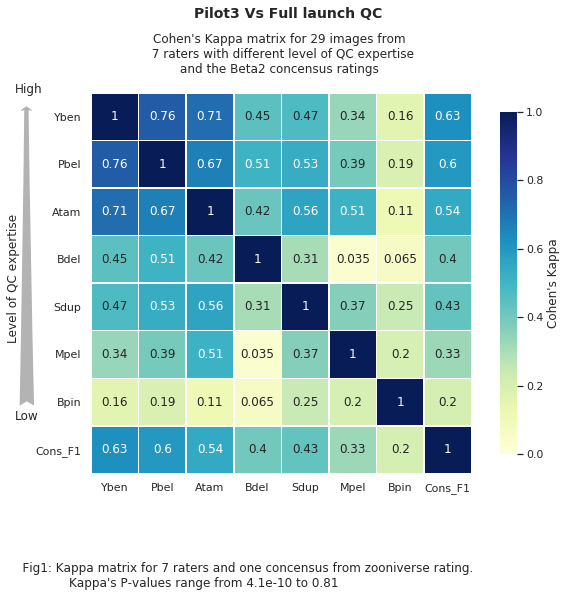

In [337]:
# Plot kappa matrix
kappa_out = pd.DataFrame(kappa_store, 
                         index=kappa_df.columns.get_values(),
                         columns=kappa_df.columns.get_values())


# Set up the matplotlib figure
f, axes = plt.subplots(figsize = (10,7))
f.subplots_adjust(hspace= .8)

f.suptitle('Pilot3 Vs Full launch QC',x=0.49,y=1.05, fontsize=14, fontweight='bold')
# Draw kappa heat map
sns.heatmap(kappa_out,vmin=0,vmax=1,cmap="YlGnBu",
            square=True,
            annot=True,
            linewidths=.5, 
            cbar_kws={"shrink": .9,"label": "Cohen's Kappa"}, 
            ax=axes)
axes.set_yticks([x+0.5 for x in range(len(kappa_df.columns))])
axes.set_yticklabels(kappa_df.columns,rotation=0)
axes.set_title("Cohen's Kappa matrix for {} images from \n  7 raters with different level of QC expertise \n and the Beta2 concensus ratings  ".format(len(merge_ratings)),
               pad=20,fontsize=12)
axes.annotate('Low', xy=(-0.17, 0.97),xytext=(-0.2, 0.14), xycoords='axes fraction',
              arrowprops=dict(arrowstyle="fancy,tail_width=1.2,head_width=01",
                            fc="0.7", ec="none",
                            linewidth =2))

# Caption
pval = np.unique(Pval_store)[-1]
txt = '''
    Fig1: Kappa matrix for 7 raters and one concensus from zooniverse rating.
                Kappa's P-values range from {:.2g} to {:.2g} '''.format(Pval_store.min(), Pval_store.max())
f.text(0.1,-0.1,txt,fontsize=12)
f.text(0.11,0.88,'High',fontsize=12)
f.text(0.10,0.62,'Level of QC expertise',fontsize=12,rotation=90)
# Save figure
f.savefig('../reports/figures/Full-Launch-vs-pilot3_qc.svg')

In [338]:
from IPython.display import Image
Image(url= "https://i.stack.imgur.com/kYNd6.png" ,width=600, height=600)

### Report tagging from Full lanch 1 raters

In [67]:
# output markings from classifications
clist=[]
for index, c in classi_unique.iterrows():
    if c['n_tagging'] > 0:
        for q in c.annotations[0]['value']:
            clist.append({'ID':c.ID, 'workflow_name':c.workflow_name,'user_name':c.user_name, 'rating':c.rating,'imgnm':c.imgnm, 
                          'x':q['x'], 'y':np.round(q['y']).astype(int), 'r':'1.5','n_tagging':c.n_tagging ,'frame':q['frame']})
    else:
        clist.append({'ID':c.ID, 'workflow_name':c.workflow_name, 'user_name':c.user_name,'rating':c.rating,'imgnm':c.imgnm, 
                          'x':float('nan'), 'y':float('nan'), 'r':float('nan'),'n_tagging':c.n_tagging ,'frame':'1'})

col_order=['ID','workflow_name','user_name','rating','x','y','r','n_tagging','imgnm','frame']
out_tag = pd.DataFrame(clist)[col_order]
out_tag.head()

,ID,workflow_name,user_name,rating,x,y,r,n_tagging,imgnm,frame
0,X3912996,Start Project 1,rubyadeline,Maybe,285.96875,199.0,1.5,2,X_3912996_anat.png,0
1,X3912996,Start Project 1,rubyadeline,Maybe,313.96875,556.0,1.5,2,X_3912996_anat.png,0
2,X0023019,Start Project 1,rubyadeline,OK,NaN,NaN,NaN,0,X_0023019_anat.png,1
3,X0021014,Start Project 1,rubyadeline,Fail,69.96875,75.0,1.5,51,X_0021014_anat.png,0
4,X0021014,Start Project 1,rubyadeline,Fail,103.96875,62.0,1.5,51,X_0021014_anat.png,0


In [68]:
# Anonymise users
user_ =['Z' + str(ii) for ii in range(len(out_tag.user_name.unique()))]
user_dict = {usr:usa for usr,usa in zip(out_tag.user_name.unique(),user_)}
out_tag.replace({'user_name':user_dict},inplace=True)
out_tag.head()

,ID,workflow_name,user_name,rating,x,y,r,n_tagging,imgnm,frame
0,X3912996,Start Project 1,Z0,Maybe,285.96875,199.0,1.5,2,X_3912996_anat.png,0
1,X3912996,Start Project 1,Z0,Maybe,313.96875,556.0,1.5,2,X_3912996_anat.png,0
2,X0023019,Start Project 1,Z0,OK,NaN,NaN,NaN,0,X_0023019_anat.png,1
3,X0021014,Start Project 1,Z0,Fail,69.96875,75.0,1.5,51,X_0021014_anat.png,0
4,X0021014,Start Project 1,Z0,Fail,103.96875,62.0,1.5,51,X_0021014_anat.png,0


In [69]:
# Extract unique IDs for each image
ids_imgnm = np.reshape([out_tag.ID.unique(),out_tag.imgnm.unique()],(2,np.shape(out_tag.ID.unique())[0]))
df_ids_imgnm = pd.DataFrame(np.sort(ids_imgnm.T, axis=0),columns=['ID', 'imgnm'])
df_ids_imgnm = df_ids_imgnm.merge(df_norm[['ID','max_value_NoExp','concensus_NoExp']], on='ID')
df_ids_imgnm.rename(columns={'max_value_NoExp':'ZconVal','concensus_NoExp':'Zcon'},inplace=True)
df_ids_imgnm.head()

,ID,imgnm,ZconVal,Zcon
0,HC0040038,HC0040038_anat.png,0.791667,OK
1,HC0040043,HC0040043_anat.png,0.625000,OK
2,HC0040045,HC0040045_anat.png,0.545455,OK
3,HC0040048,HC0040048_anat.png,0.440000,OK
4,HC0040050,HC0040050_anat.png,0.500000,OK


In [70]:
# Populate patches
patches=list()
for ind, row in df_ids_imgnm.iterrows():
    out_tmp = out_tag[out_tag['ID'] == row.ID]
    patches.append([(row_.ID,row_.user_name,row_.rating,
                     row_.x,row_.y,row_.n_tagging,
                     row.ZconVal,row.Zcon) for ind,row_ in out_tmp.iterrows()])
patches_raw = patches

patches = [x for x in sum(patches,[]) if str(x[3]) != 'nan']
patches_df = pd.DataFrame(patches, columns=['ID','user_name','rating','x','y','n_tagging','cons','rate'])
#patches_df.replace({'user_name':rater_dict},inplace=True)
display(patches_df.head())

patches_raw = [x for x in sum(patches_raw,[])]
patches_raw_df = pd.DataFrame(patches_raw, columns=['ID','user_name','rating','x','y','n_tagging','cons','rate'])
#patches_raw_df.replace({'user_name':rater_dict},inplace=True)
display(patches_raw_df.head())

,ID,user_name,rating,x,y,n_tagging,cons,rate
0,HC0040038,Z2,Maybe,100.000000,297.0,2,0.791667,OK
1,HC0040038,Z2,Maybe,508.000000,586.0,2,0.791667,OK
2,HC0040038,Z6,Maybe,121.303444,281.0,1,0.791667,OK
3,HC0040038,Z7,Maybe,94.468750,298.0,3,0.791667,OK
4,HC0040038,Z7,Maybe,316.468750,302.0,3,0.791667,OK


,ID,user_name,rating,x,y,n_tagging,cons,rate
0,HC0040038,Z0,OK,NaN,NaN,0,0.791667,OK
1,HC0040038,Z1,OK,NaN,NaN,0,0.791667,OK
2,HC0040038,Z2,Maybe,100.0,297.0,2,0.791667,OK
3,HC0040038,Z2,Maybe,508.0,586.0,2,0.791667,OK
4,HC0040038,Z3,OK,NaN,NaN,0,0.791667,OK


In [71]:
# Create custom color map
from matplotlib.colors import LinearSegmentedColormap , ListedColormap
from PIL import Image
def _cmap_from_image_path(img_path):
        img = Image.open(img_path)
        img = img.resize((256, img.height))
        colours = (img.getpixel((x, 0)) for x in range(256))
        colours = [(r/255, g/255, b/255, a/255) for (r, g, b, a) in colours]
        return colours,LinearSegmentedColormap.from_list('from_image', colours)

    
coll,a=_cmap_from_image_path('../data/Misc/custom_ColBar.png')
#invert color map
coll_r = ListedColormap(coll[::-1])

In [85]:
# set threshold and rating
rate_val = 'Fail'
cons_thr = 0.6
thr_sign = 'h'

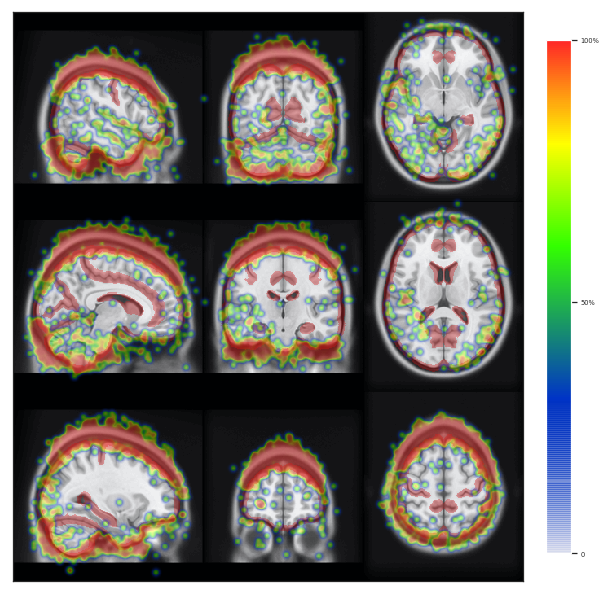

In [86]:
from heatmappy import Heatmapper
from PIL import Image
sns.set(style="white")
# plot heat map on the template
f, axes = plt.subplots(1, 1,figsize = (10,14))
f.subplots_adjust(hspace= .8)
#f.suptitle('Full launch 1 Zooniverse QC',x=0.49,y=.83, fontsize=14, fontweight='bold')
sns.set(font_scale=0.6)
img = Image.open('../data/Misc/template_stereotaxic_v3.png')
#axes.set_title('Tagging from expert raters for Maybe images')

# set color different for each rater
list_tagger = out_tmp.user_name.unique()
list_tagger.sort()
if thr_sign == 'h':
    out_tmp = patches_df.loc[(patches_df["rate"] == rate_val) &
                            (patches_df["cons"] > cons_thr), :]
elif thr_sign == 'l':
    out_tmp = patches_df.loc[(patches_df["rate"] == rate_val) &
                            (patches_df["cons"] < cons_thr), :]
else:
    raise Exception('thr_sign should be either ''h'' or ''l''. The value of thr_sign was: {}'.format(thr_sign))

tag_ = np.zeros((len(out_tmp.ID.unique()),len(list_tagger)))
for i_id, v_id in enumerate (out_tmp.ID.unique()):
    out_ = out_tmp[out_tmp['ID'] == v_id]
    tag_[i_id,:] = [sum(out_[out_['user_name'] == rater].n_tagging.unique()) for rater in list_tagger]
# tagging weight   
norm1 = tag_/ np.linalg.norm(tag_)
tt =[norm1[i,:].sum() for i in range(len(norm1))]

#select specific patches
if thr_sign == 'h':
    patch_ = [(rr.x,rr.y)  for ii,rr in patches_df.iterrows() if rr.rate == rate_val and rr.cons > cons_thr ]
elif thr_sign == 'l':
    patch_ = [(rr.x,rr.y)  for ii,rr in patches_df.iterrows() if rr.rate == rate_val and rr.cons < cons_thr ]
else:
    raise Exception('thr_sign should be either ''h'' or ''l''. The value of thr_sign was: {}'.format(thr_sign))


heatmapper = Heatmapper(opacity=0.4,
                        point_diameter=15,
                        point_strength =1/np.max(tt),
                        colours=a)
heatmap= heatmapper.heatmap_on_img(patch_, img)

im = axes.imshow(heatmap,cmap=coll_r)
axes.set_yticklabels([])
axes.set_xticklabels([])

cbar = plt.colorbar(im, orientation='vertical', ticks=[0, 125, 255],fraction=0.046, pad=0.04,ax=axes)
cbar.ax.set_yticklabels(['0', '50%', '100%'])

img.close()
heatmap.close()
f.savefig('../reports/figures/Results/Heat_maps/Zooniv_{}_cons_{}_{}.svg'.format(rate_val,str(cons_thr),thr_sign))


In [80]:
colors_tagger_h=["#5accbd",
"#d241a4",
"#57bf41",
"#a04bc5",
"#91bc3c",
"#626ce1",
"#c6ba3a",
"#7456b4",
"#52c569",
"#d07be0",
"#3f9130",
"#d9447c",
"#4dc690",
"#d43f4b",
"#48bfe0",
"#d5572c",
"#638ae0",
"#dd9535",
"#5864a4",
"#a69730",
"#995297",
"#69862a",
"#ba9adf",
"#2f7038",
"#dd82b0",
"#47935a",
"#9d436e",
"#82bc75",
"#9f4852",
"#3e9f86",
"#a1502b",
"#5995cc",
"#77641b",
"#e07e7d",
"#277257",
"#df996b",
"#6e9251",
"#a06f33",
"#b5b670",
"#556121",
"#918747"]

In [81]:
import re
def sorted_nicely( l ):
    """ Sorts the given iterable in the way that is expected.
 
    Required arguments:
    l -- The iterable to be sorted.
 
    """
    convert = lambda text: int(text) if text.isdigit() else text
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)', key)]
    return sorted(l, key = alphanum_key)

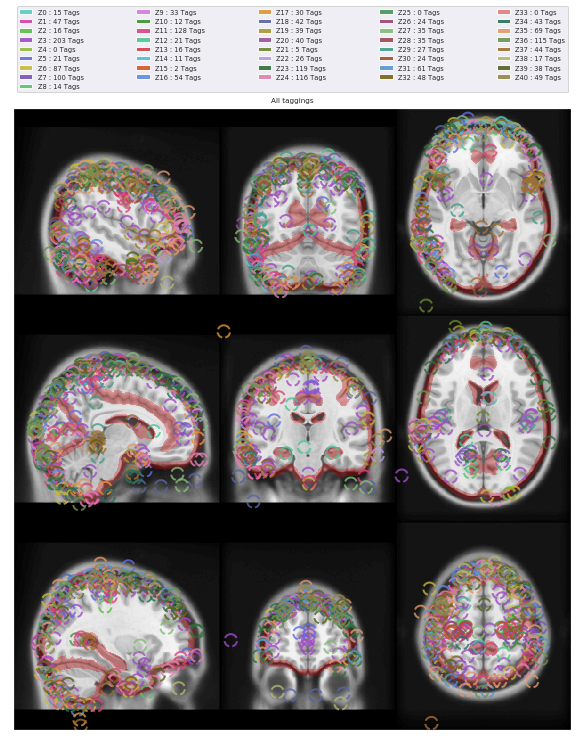

In [82]:
from matplotlib.collections import PatchCollection
from matplotlib.patches import Circle, Arrow

#Set Template image as background
fig = plt.figure(figsize=(10,14))
ax = fig.add_subplot(111)
im = plt.imread('../data/Misc/template_stereotaxic_v3.png')
ax.set_title('All taggings')
ax.imshow(im)
#fig.suptitle('Pilot2 QC',x=0.51,y=.87, fontsize=14, fontweight='bold')
# Plot tags
sns.set(font_scale=0.6)

if thr_sign == 'h':
    out_tmp = patches_raw_df.loc[(patches_raw_df["rate"] == rate_val) &
                                 (patches_raw_df["cons"] > cons_thr), :]
elif thr_sign == 'l':
    out_tmp = patches_raw_df.loc[(patches_raw_df["rate"] == rate_val) &
                                 (patches_raw_df["cons"] < cons_thr), :]
else:
    raise Exception('thr_sign should be either ''h'' or ''l''. The value of thr_sign was: {}'.format(thr_sign))


# set color different for each rater
list_tagger = out_tmp.user_name.unique()
list_tagger = sorted_nicely(list_tagger)
colors_tagger = sns.color_palette("Set3", len(list_tagger))

for idx,tagger in enumerate(list_tagger):
    out_tagger = out_tmp[out_tmp['user_name'] == tagger]
    c = [Circle((rowtag.x,rowtag.y), 7) 
         for itag,rowtag in out_tagger.iterrows()]
    p =  PatchCollection(c,facecolor='none', 
                        edgecolor=colors_tagger_h[idx], 
                        alpha=.8,
                        linewidth=2,
                        linestyle='dashed')
    ax.add_collection(p)


#Set figure Tags labels       
tag_ = np.zeros((len(out_tmp.ID.unique()),len(list_tagger)))
l = list()
labels = list()
for i_id, v_id in enumerate (out_tmp.ID.unique()):
    out_ = out_tmp[out_tmp['ID'] == v_id]
    tag_[i_id,:]= [sum(out_[out_['user_name'] == rater].n_tagging.unique()) for rater in list_tagger]

for rater_id, rater in enumerate(list_tagger):
    l.append(Circle((None,None), facecolor=colors_tagger_h[rater_id], alpha=0.9))
    labels.append('{} : {:g} Tags'.format(rater,tag_.sum(axis=0)[rater_id]))
        
ax.legend(handles=l,labels=labels, 
          bbox_to_anchor=(0., 1.02, 1., .2), 
          mode='expand', ncol=5, loc="lower right")
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.grid(False)
img.close()
fig.savefig('../reports/figures/Results/Heat_maps/Zooniv_tag_{}_cons_{}_{}.svg'.format(rate_val,str(cons_thr),thr_sign))

In [150]:
# set color different for each rater
list_tagger = out_tag.user_name.unique()
colors_tagger = sns.color_palette("Set2", len(list_tagger))

In [79]:
# Populate patches
patches=list()
for ind, row in df_ids_imgnm.iterrows():
    out_tmp = out_tag[out_tag['ID'] == row.ID]
    patches.append([(row_.x,row_.y,row.max_value_NoExp,row.concensus_NoExp) for ind,row_ in out_tmp.iterrows()])

patches = [x for x in sum(patches,[]) if str(x[0]) != 'nan']
patches_df = pd.DataFrame(patches, columns=['x','y','cons','rate'])
patches_df.head()

,x,y,cons,rate
0,100.000000,297.0,0.791667,OK
1,508.000000,586.0,0.791667,OK
2,121.303444,281.0,0.791667,OK
3,94.468750,298.0,0.791667,OK
4,316.468750,302.0,0.791667,OK


### Plot all tagging

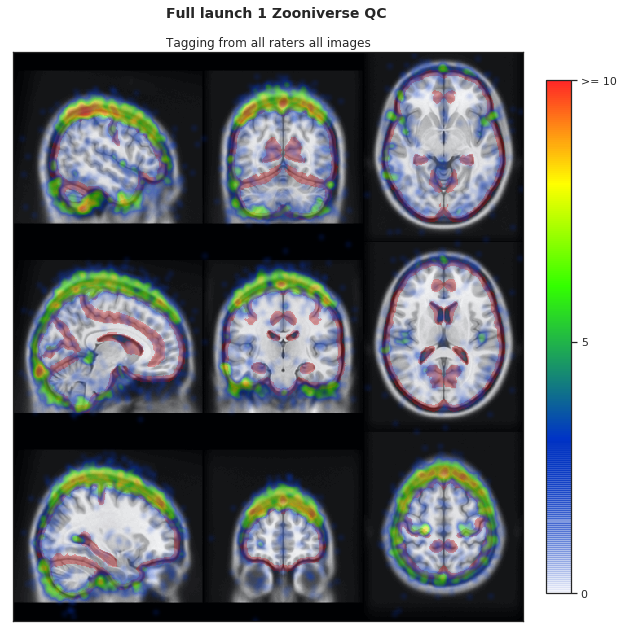

In [94]:
from heatmappy import Heatmapper
from PIL import Image

# plot heat map on the template
f, axes = plt.subplots(1, 1,figsize = (10,14))
f.subplots_adjust(hspace= .8)
f.suptitle('Full launch 1 Zooniverse QC',x=0.49,y=.83, fontsize=14, fontweight='bold')

img = Image.open('../data/Misc/template_stereotaxic_v3.png')
axes.set_title('Tagging from all raters all images')

heatmapper = Heatmapper(opacity=0.5,
                        point_diameter=15,
                        point_strength = 0.1,
                        colours=a)
heatmap= heatmapper.heatmap_on_img(patches_df[['x','y']].as_matrix(), img)

im = axes.imshow(heatmap,cmap=coll_r)
axes.set_yticklabels([])
axes.set_xticklabels([])

cbar = plt.colorbar(im, orientation='vertical', ticks=[0, 125, 255],fraction=0.046, pad=0.04,ax=axes)
cbar.ax.set_yticklabels(['0', '5', '>= 10'])

img.close()
heatmap.close()
f.savefig('../reports/figures/Full_launch1_qc_heatmap_tags.svg')

### Compare kappa within non-expert from full launch 1

### Plot maybe image tagging

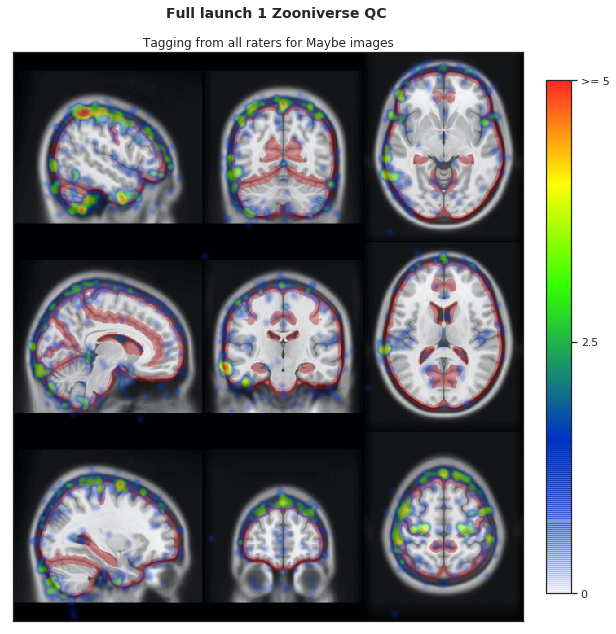

In [152]:
from heatmappy import Heatmapper
from PIL import Image

# plot heat map on the template
f, axes = plt.subplots(1, 1,figsize = (10,14))
f.subplots_adjust(hspace= .8)
f.suptitle('Full launch 1 Zooniverse QC',x=0.49,y=.83, fontsize=14, fontweight='bold')

img = Image.open('../data/Misc/template_stereotaxic_v3.png')
axes.set_title('Tagging from all raters for Maybe images')

#select specific patches
patch_ = [(rr.x,rr.y)  for ii,rr in patches_df.iterrows() if rr.rate == 'Maybe' and rr.cons >= 0 ]
heatmapper = Heatmapper(opacity=0.5,
                        point_diameter=15,
                        point_strength = 0.2,
                        colours=a)
heatmap= heatmapper.heatmap_on_img(patch_, img)

im = axes.imshow(heatmap,cmap=coll_r)
axes.set_yticklabels([])
axes.set_xticklabels([])

cbar = plt.colorbar(im, orientation='vertical', ticks=[0, 125, 255],fraction=0.046, pad=0.04,ax=axes)
cbar.ax.set_yticklabels(['0', '2.5', '>= 5'])

img.close()
heatmap.close()
f.savefig('../reports/figures/Full_launch1_qc_heatmap_Maybe_tags.svg')


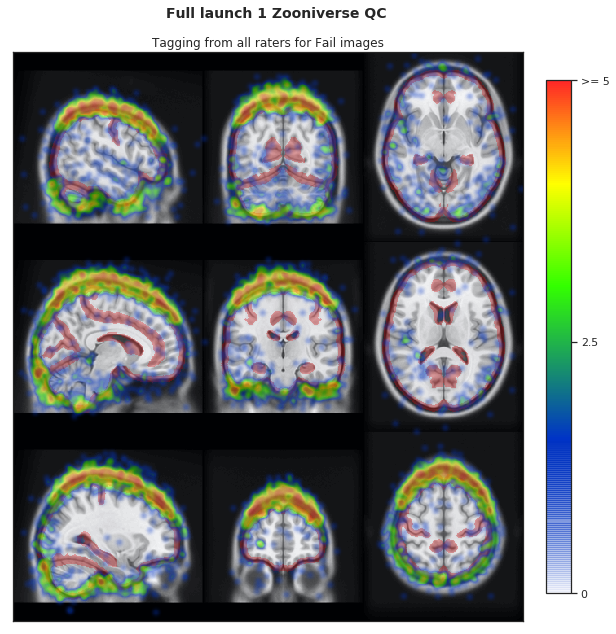

In [153]:
from heatmappy import Heatmapper
from PIL import Image

# plot heat map on the template
f, axes = plt.subplots(1, 1,figsize = (10,14))
f.subplots_adjust(hspace= .8)
f.suptitle('Full launch 1 Zooniverse QC',x=0.49,y=.83, fontsize=14, fontweight='bold')

img = Image.open('../data/Misc/template_stereotaxic_v3.png')
axes.set_title('Tagging from all raters for Fail images')

#select specific patches
patch_ = [(rr.x,rr.y)  for ii,rr in patches_df.iterrows() if rr.rate == 'Fail' and rr.cons >= 0 ]
heatmapper = Heatmapper(opacity=0.5,
                        point_diameter=15,
                        point_strength = 0.2,
                        colours=a)
heatmap= heatmapper.heatmap_on_img(patch_, img)

im = axes.imshow(heatmap,cmap=coll_r)
axes.set_yticklabels([])
axes.set_xticklabels([])

cbar = plt.colorbar(im, orientation='vertical', ticks=[0, 125, 255],fraction=0.046, pad=0.04,ax=axes)
cbar.ax.set_yticklabels(['0', '2.5', '>= 5'])

img.close()
heatmap.close()
f.savefig('../reports/figures/Full_launch1_qc_heatmap_Fail_tags.svg')


In [122]:
# How many rating per user
user_count = classi_unique.user_name.value_counts()
user_count

rubyadeline                           100
1010101                               100
Uganalandia                           100
sueburr                               100
MsImmortal                            100
RLINDS4026                            100
lobusparietalis                       100
hallkr                                 98
narguedasn                             95
juliejo                                87
ashherr17                              76
kitchenmi                              68
alinanaseer                            64
ChaoticK                               54
Michaelspili                           54
alyssalewis4                           49
Dillen                                 48
AlyPereira21                           44
AndrejGalinac                          44
1a2r3u4n                               43
Hmelting                               41
sanitha.yang                           39
Service55                              39
not-logged-in-4d11726c1f714afe8e57

In [123]:
# Select only raters how completed 100 images
list_user = user_count.index
list_user = list_user[user_count.values==100]
user_count[list_user]

rubyadeline        100
1010101            100
Uganalandia        100
sueburr            100
MsImmortal         100
RLINDS4026         100
lobusparietalis    100
Name: user_name, dtype: int64

In [124]:
concat_rating = [classi_unique[classi_unique.user_name == user][['ID','rating']].rename(columns={'rating': user})
                  for user in list_user]

df_ratings_F1 = reduce(lambda left,right: pd.merge(left,right,how='outer',on='ID'), concat_rating).apply(lambda x: x.str.strip() if x.dtype == "object" else x)
df_ratings_F1.replace({'OK':1,'Maybe':2, 'Fail':3}, inplace=True)
df_ratings_F1.head()

,ID,rubyadeline,1010101,Uganalandia,sueburr,MsImmortal,RLINDS4026,lobusparietalis
0,X3912996,2,1,2,2,2,2,1
1,X0023019,1,1,2,2,2,2,2
2,X0021014,3,3,1,3,3,3,3
3,HC0040053,2,1,2,1,2,3,1
4,X1038415,1,3,1,2,2,3,1


In [125]:
# Percenteage of agrrement between raters with R package IRR
agree_ = df_ratings_F1.drop(columns='ID',axis=1)
%Rpush agree_
agree_n = %R agree(agree_)
print(agree_n)

 Percentage agreement (Tolerance=0)

 Subjects = 100 
   Raters = 7 
  %-agree = 12 



In [126]:
# Get Kappa score out of all different combination of ratings
kappa_df  = df_ratings_F1.drop(columns='ID',axis=1)
kappa_df.rename(columns={'1010101':'X1010101'},inplace=True)
kappa_store, Pval_store = kappa_score(kappa_df)
mean_kap = np.mean(kappa_store[np.triu_indices(len(kappa_store),k=1)])
std_kap = np.std(kappa_store[np.triu_indices(len(kappa_store),k=1)])
print('Mean Kappa : {0:.2f} , std : {1:.2f}\n'.format(mean_kap, std_kap))

#calculte the over all kappa values of all ratings
%Rpush kappa_df
fleiss_kappa = %R kappam.fleiss(kappa_df,c(0,1,2))
print(fleiss_kappa)

Mean Kappa : 0.29 , std : 0.08

 Fleiss' Kappa for m Raters

 Subjects = 100 
   Raters = 7 
    Kappa = 0.195 

        z = 12.5 
  p-value = 0 



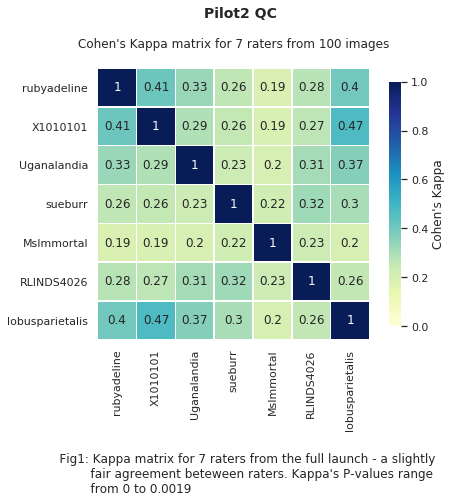

In [127]:
# Plot kappa matrix
kappa_out = pd.DataFrame(kappa_store, 
                         index=kappa_df.columns.get_values(),
                         columns=kappa_df.columns.get_values())


# Set up the matplotlib figure
f, axes = plt.subplots(figsize = (7,5))
f.subplots_adjust(hspace= .8)

f.suptitle('Pilot2 QC',x=0.49,y=1.05, fontsize=14, fontweight='bold')
# Draw kappa heat map
sns.heatmap(kappa_out,vmin=0,vmax=1,cmap="YlGnBu",
            square=True,
            annot=True,
            linewidths=.5, 
            cbar_kws={"shrink": .9,"label": "Cohen's Kappa"}, 
            ax=axes)
axes.set_yticks([x+0.5 for x in range(len(kappa_df.columns))])
axes.set_yticklabels(kappa_df.columns,rotation=0)
axes.set_title("Cohen's Kappa matrix for 7 raters from {} images".format(len(df_ratings)),pad=20,fontsize=12)

# Caption
pval = np.unique(Pval_store)[-1]
txt = '''
    Fig1: Kappa matrix for 7 raters from the full launch - a slightly 
            fair agreement beteween raters. Kappa's P-values range 
            from {:.2g} to {:.2g} '''.format(Pval_store.min(), Pval_store.max())
f.text(.1,-0.3,txt,fontsize=12)
# Save figure
f.savefig('../reports/figures/full_launch1_qc.svg')

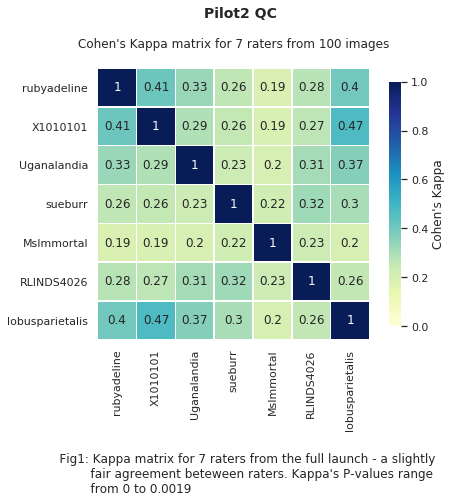

In [128]:
# Plot kappa matrix
kappa_out = pd.DataFrame(kappa_store, 
                         index=kappa_df.columns.get_values(),
                         columns=kappa_df.columns.get_values())


# Set up the matplotlib figure
f, axes = plt.subplots(figsize = (7,5))
f.subplots_adjust(hspace= .8)

f.suptitle('Pilot2 QC',x=0.49,y=1.05, fontsize=14, fontweight='bold')
# Draw kappa heat map
sns.heatmap(kappa_out,vmin=0,vmax=1,cmap="YlGnBu",
            square=True,
            annot=True,
            linewidths=.5, 
            cbar_kws={"shrink": .9,"label": "Cohen's Kappa"}, 
            ax=axes)
axes.set_yticks([x+0.5 for x in range(len(kappa_df.columns))])
axes.set_yticklabels(kappa_df.columns,rotation=0)
axes.set_title("Cohen's Kappa matrix for 7 raters from {} images".format(len(df_ratings)),pad=20,fontsize=12)

# Caption
pval = np.unique(Pval_store)[-1]
txt = '''
    Fig1: Kappa matrix for 7 raters from the full launch - a slightly 
            fair agreement beteween raters. Kappa's P-values range 
            from {:.2g} to {:.2g} '''.format(Pval_store.min(), Pval_store.max())
f.text(.1,-0.3,txt,fontsize=12)
# Save figure
f.savefig('../reports/figures/full_launch1_qc.svg')